# Stock Portfolio Analysis using Time Series Forecasting

## Getting the necessary packages

In [1]:
#installing the packages necessary (run this cell if all the packages are not installed)
!pip install pandas yfinance matplotlib pmdarima numpy statsmodels

In [2]:
#importing the packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Fetching the data

In [3]:
#in this project, we are taking a portfolio that consists of 10 CPG manufacturing companies
#KO - Coca-Cola
#PEP - PepsiCo
#CL - Colgate-Palmolive
#KHC - The Kraft Heinz Company
#MDLZ - Mondelez International
#GIS - General Mills
#EL - Estée Lauder
#KMB - Kimberly-Clark
#STZ - Constellation Brands
#CLX - The Clorox Company

stock_list = ["PEP", "KO", "CL", "KHC", "MDLZ", "GIS", "EL", "KMB", "STZ", "CLX"]


In [4]:
#fetching the stocks data from yahoo finance for 5 years

start_date = "2018-01-01"
end_date = "2023-01-01"

stock_data = yf.download(stock_list, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  10 of 10 completed


In [5]:
stock_data.head()

,CL,CLX,EL,GIS,KHC,KMB,KO,MDLZ,PEP,STZ
Date,,,,,,,,,,
2018-01-02,65.018921,123.055397,120.773010,47.980312,59.052315,98.012161,37.955715,37.304008,99.948692,208.570724
2018-01-03,64.767952,121.731354,122.694550,47.728378,59.044640,96.374115,37.872360,37.453545,99.686264,209.436081
2018-01-04,65.183319,123.649437,123.271973,48.280998,59.734711,97.485359,38.405792,37.541500,100.177307,207.861847
2018-01-05,65.261200,123.683449,123.044807,48.695454,59.681023,97.271347,38.397446,38.025288,100.465134,202.421112
2018-01-08,65.356392,124.286041,123.972427,48.857998,60.171715,98.308495,38.339104,37.831768,99.889435,199.622482


In [6]:
stock_data.shape

(1259, 10)

## Cleaning and preprocessing

In [7]:
#checking for null values
for stock, data in stock_data.items():
    missing_values = data.isnull().sum()
    if missing_values > 0:
        print(f"Missing values in {stock}: {missing_values}")

In [8]:
#there are no missing values in the data
#in case there will be any missing values in future, 
#this cod will replace the missing/null values with previous day value

for stock, data in stock_data.items():
    stock_data[stock].fillna(method='ffill', inplace=True)

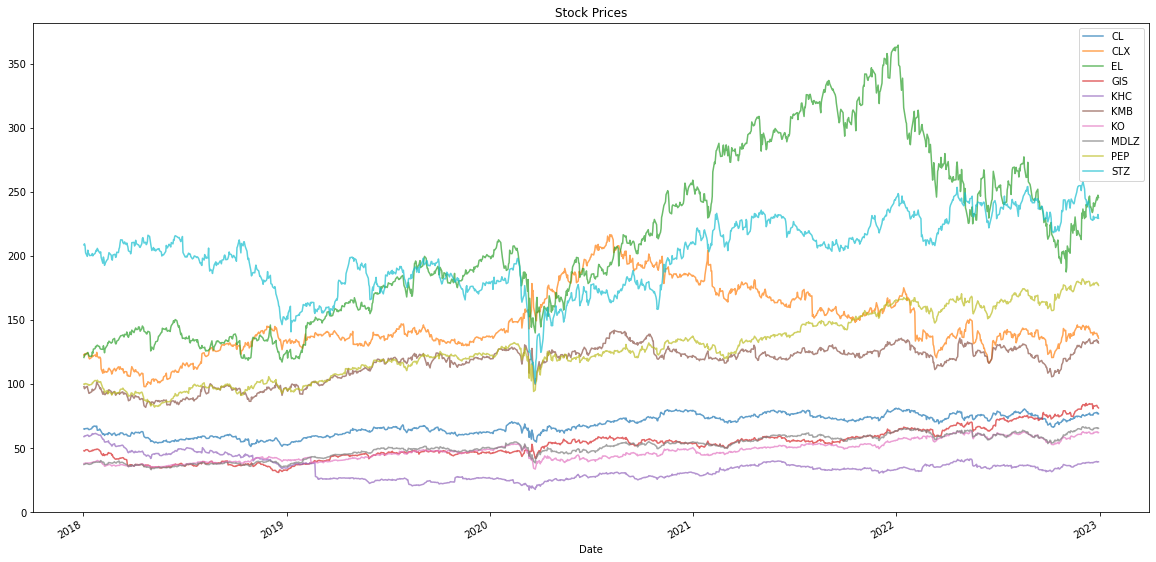

In [9]:
#visualizing each stock in a line graph
plt.figure(figsize=(20, 10))

for stock, data in stock_data.items():
    data.plot(label=stock, alpha=0.7)

plt.title('Stock Prices')
plt.legend()
plt.show()


#### Observation:  We can see from the above plot that there was a slight down decrease in closing price of all the stocks except for CLX - Clorax in the first quater of 2020

In [10]:
#handling the outliers iterating through each stock
for cpg in stock_list:
    temp_stock_data = stock_data[cpg]
    
    #we are clipping the extreme values so that the data is not skewed
    #the quantiles can be customized as per the requirement
    #now we are taking lower and upper threshold values as 0.01 and 0.99
    lower_threshold = temp_stock_data.quantile(0.05)
    upper_threshold = temp_stock_data.quantile(0.95)
    temp_stock_data_clipped = temp_stock_data.clip(lower=lower_threshold, upper=upper_threshold)
    stock_data[cpg] = temp_stock_data_clipped

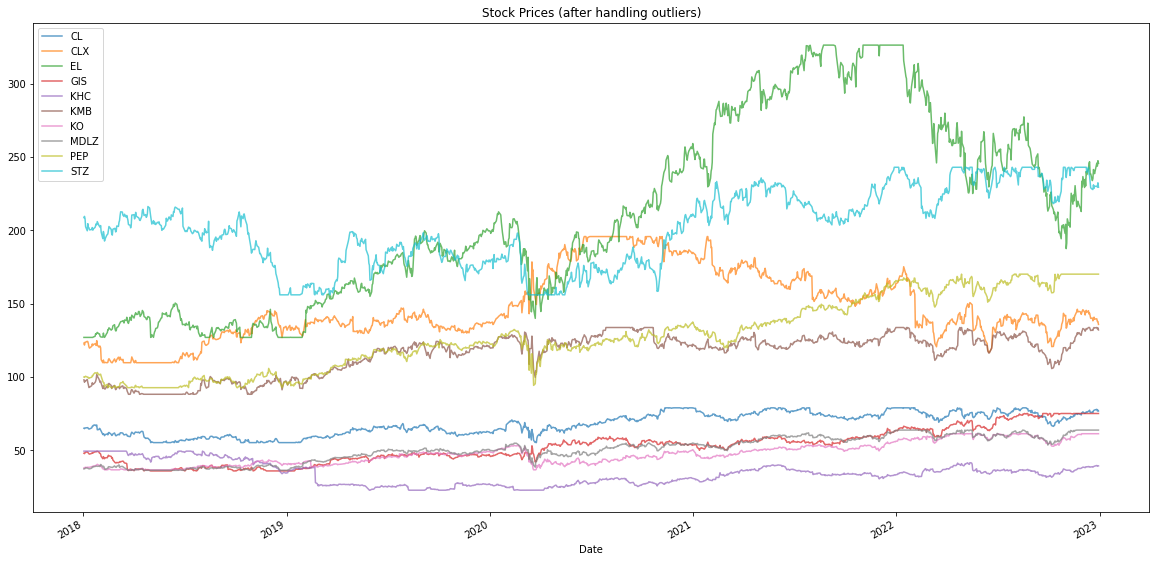

In [11]:
#visualizing each stock in a line graph after handling the outliers
plt.figure(figsize=(20, 10))

for stock, data in stock_data.items():
    data.plot(label=stock, alpha=0.7)

plt.title('Stock Prices (after handling outliers)')
plt.legend()
plt.show()

## Daily Returns

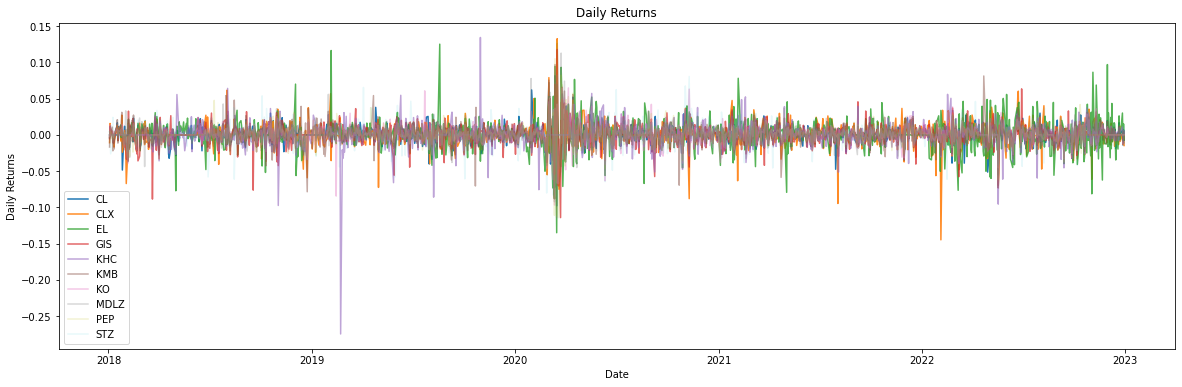

In [12]:
#we can calculate daily returns with pct_change()
stock_returns = stock_data.pct_change().dropna()

#visualizing pct change
plt.figure(figsize=(20, 6))
for i, stock in enumerate(stock_returns.columns):
    alpha_value = 1.0 - (i / len(stock_returns.columns))  # Unique transparency for each stock
    plt.plot(stock_returns.index, stock_returns[stock], label=stock, alpha=alpha_value)

plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.show()

## Sharpe Ratio

{'CL': 0.2646737122737469, 'CLX': 0.2057305613815361, 'EL': 0.5737093049587931, 'GIS': 0.5106232281152189, 'KHC': -0.022889698764033416, 'KMB': 0.379709554915193, 'KO': 0.5765792012092488, 'MDLZ': 0.6112788639981831, 'PEP': 0.6025181323585354, 'STZ': 0.19800770222593128}


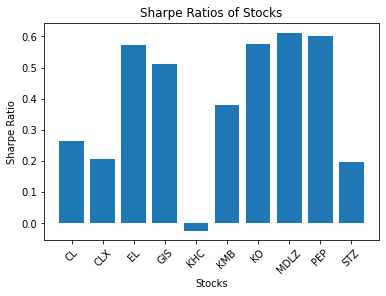

In [13]:
# Calculate Sharpe ratio for each stock
sharpe_ratio = {}
for stock in stock_returns.columns:
    daily_ret_mean = stock_returns[stock].mean()
    daily_ret_stddev = stock_returns[stock].std()
    temp_sharpe = np.sqrt(252) * (daily_ret_mean / daily_ret_stddev)
    sharpe_ratio[stock] = temp_sharpe

print(sharpe_ratio)

# Visualize Sharpe ratios
plt.bar(sharpe_ratio.keys(), sharpe_ratio.values())
plt.title('Sharpe Ratios of Stocks')
plt.xlabel('Stocks')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=45)
plt.show()

### Observation: Only the KHC has negative sharpe ratio and it might not offer better returns. EL, KO, MDLZ and PEP offer better risk adjustment when compared to other stocks.

## Stationarity Check

In [14]:
# Check for stationarity using ADF test
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

for stock, data in stock_data.items():
    print(f"Stationarity check for {stock}:")
    check_stationarity(data)


Stationarity check for CL:
ADF Statistic: -1.5826421547268739
p-value: 0.4923067994903943
Critical Values:
   1%: -3.4356006420838963
   5%: -2.8638586845641063
   10%: -2.5680044958343604
Stationarity check for CLX:
ADF Statistic: -1.5510385526225081
p-value: 0.5081293843381302
Critical Values:
   1%: -3.4356133204636095
   5%: -2.8638642784217305
   10%: -2.5680074748794373
Stationarity check for EL:
ADF Statistic: -1.4307873079853848
p-value: 0.5674305734402605
Critical Values:
   1%: -3.4355629707955395
   5%: -2.863842063387667
   10%: -2.567995644141416
Stationarity check for GIS:
ADF Statistic: 0.05954505375604221
p-value: 0.9631880104623415
Critical Values:
   1%: -3.4355754676859886
   5%: -2.8638475772391665
   10%: -2.5679985805677017
Stationarity check for KHC:
ADF Statistic: -2.0229239226670135
p-value: 0.2766130815828869
Critical Values:
   1%: -3.4355588184378574
   5%: -2.8638402312881497
   10%: -2.5679946684494275
Stationarity check for KMB:
ADF Statistic: -1.91406599

Here are the observations and insights from the ADF test results:

1. **Interpretation of ADF Statistic and p-values**:
   - If the ADF statistic is less than the critical values and the corresponding p-value is lower than a specific threshold (e.g., 0.05), you can reject the null hypothesis, indicating the time series is likely stationary.
   - A higher p-value suggests a failure to reject the null hypothesis, indicating the time series might not be stationary.

2. **Individual Stock Observations**:
   - **KHC**: The ADF statistic is significantly low, and the p-value is below 0.05, suggesting the data is likely stationary.
   - **Others**: For most stocks, the ADF statistics are negative, which is a good sign for stationarity. However, the p-values are relatively high (above 0.05) for most stocks, indicating that the data might not be stationary.

3. **Actionable Insights**:
   - Stocks like KHC show stronger evidence of stationarity, which could potentially allow for easier modeling with time series techniques.
   - For stocks with higher p-values (e.g., KO, PEP, EL, etc.), further analysis or preprocessing steps might be needed to make the data stationary before applying time series models.

4. **Considerations**:
   - These results indicate that most stock data might not be stationary, possibly requiring transformations or differencing to achieve stationarity before modeling.
   - Other stationarity checks or transformations like differencing could be attempted to make the data suitable for time series analysis.

Overall, the ADF test results suggest that several stock time series might not be stationary based on the p-values obtained. For more accurate time series analysis and forecasting, achieving stationarity in the data might be necessary.

## Seasonal Decomposition

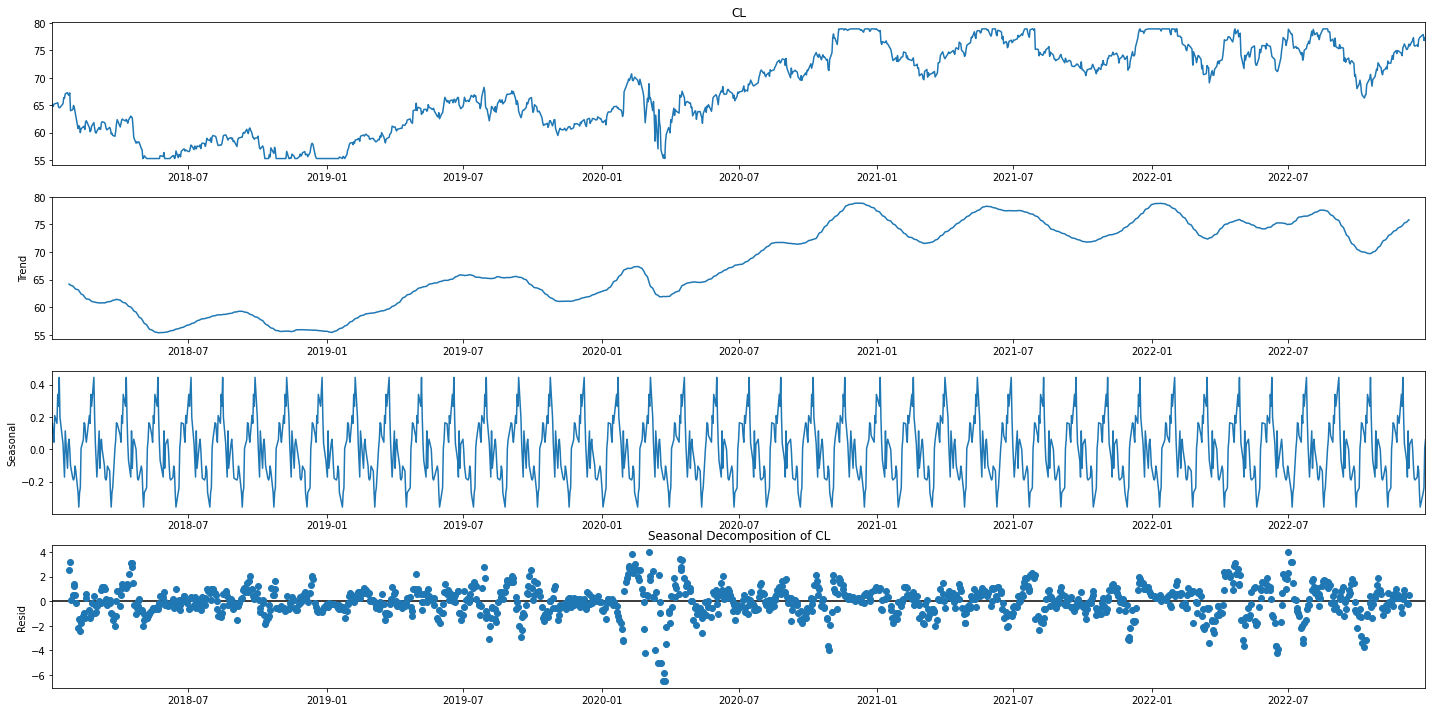

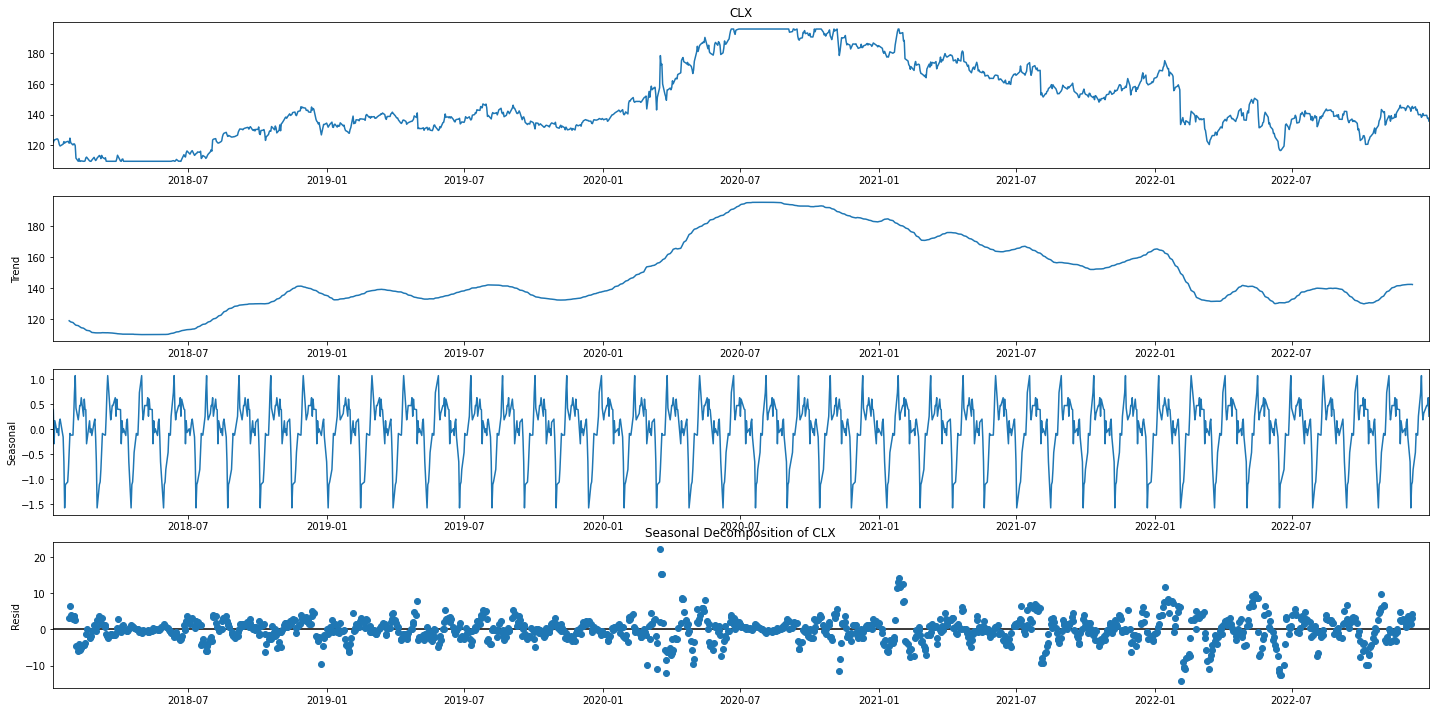

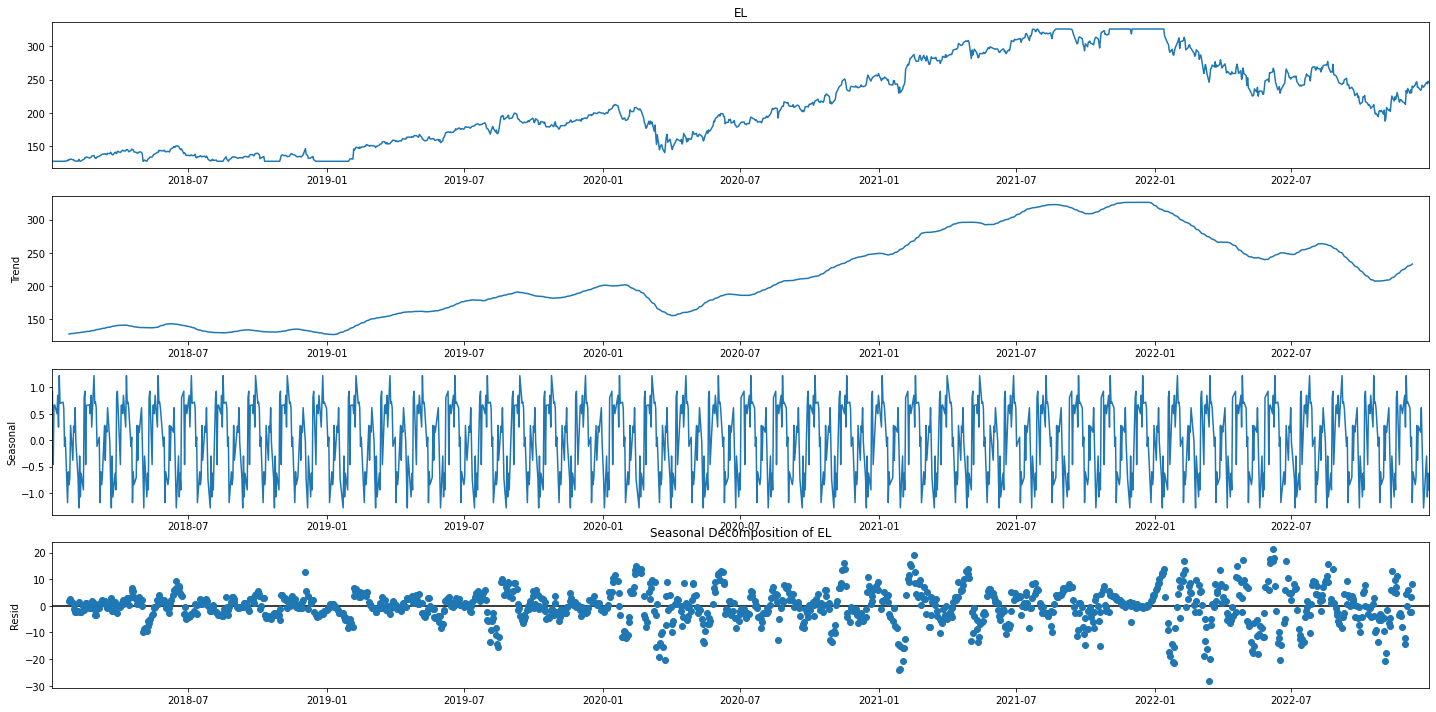

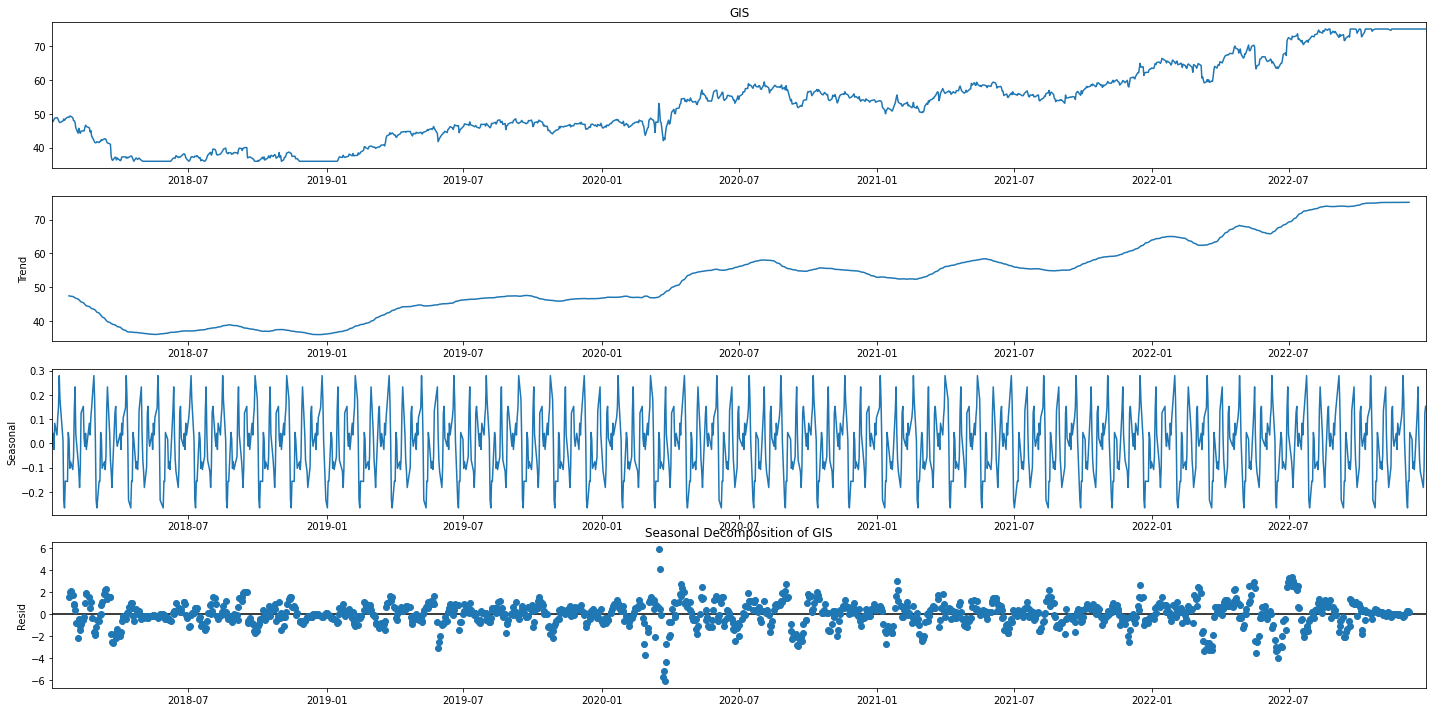

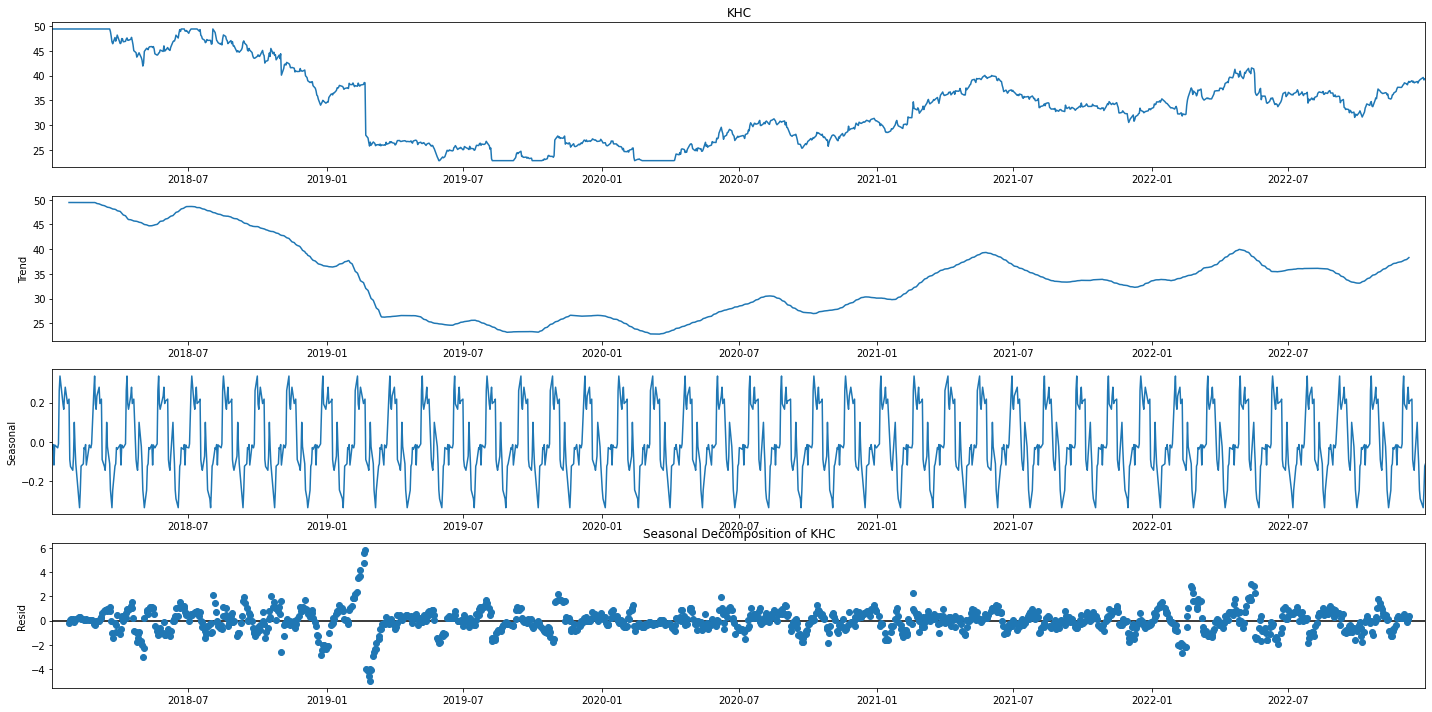

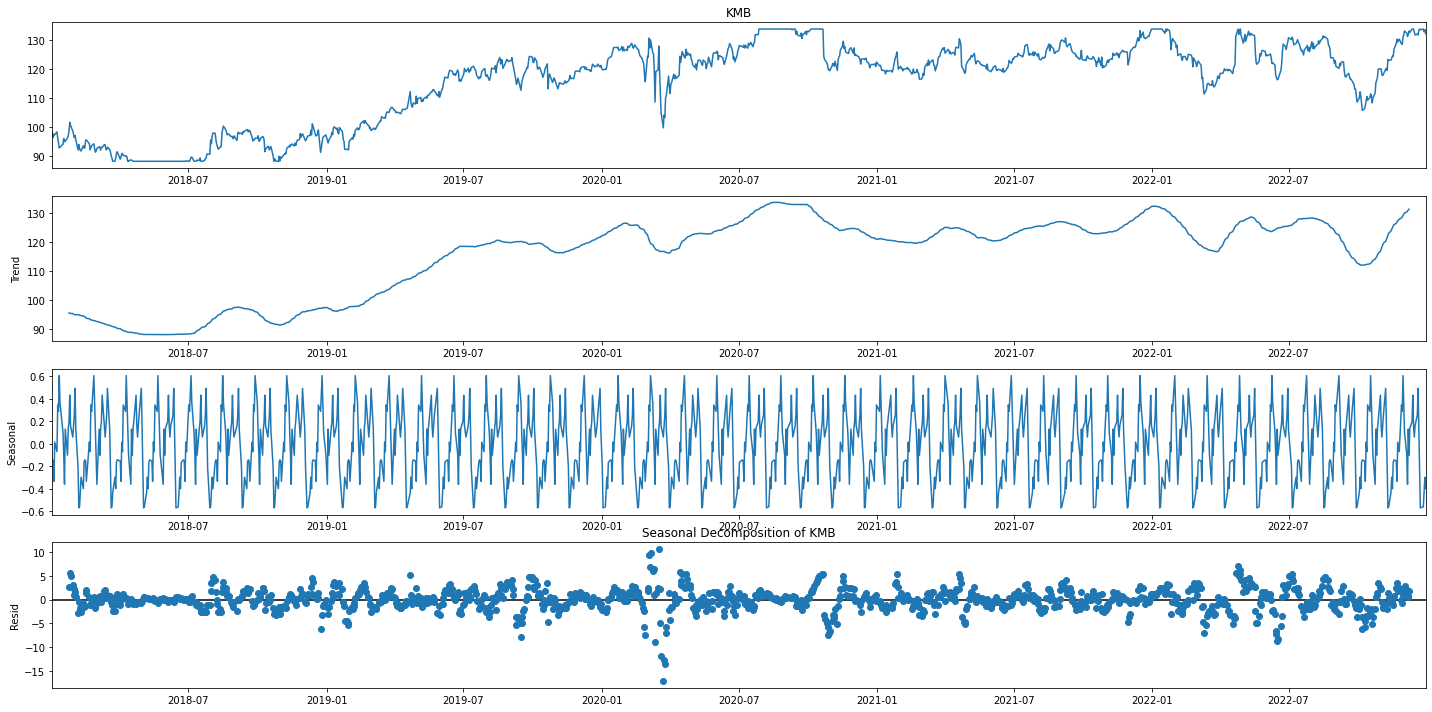

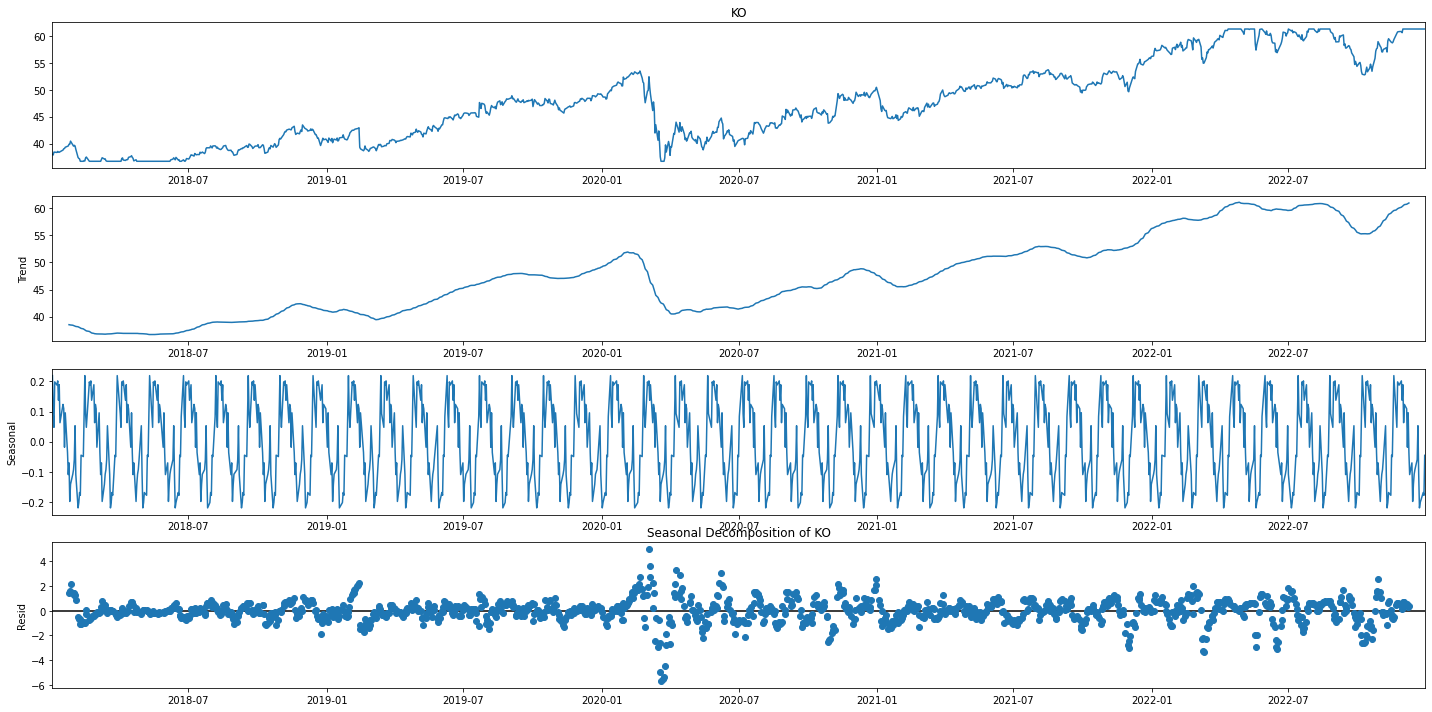

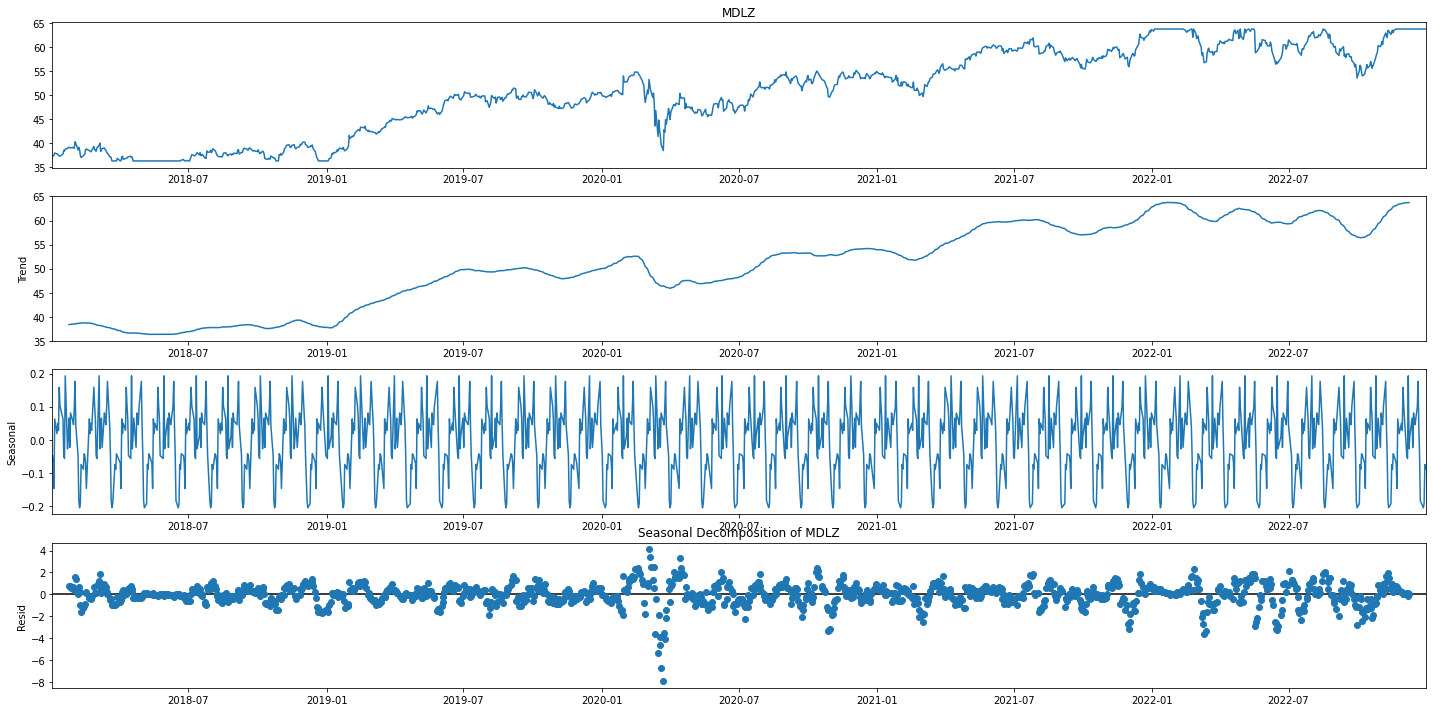

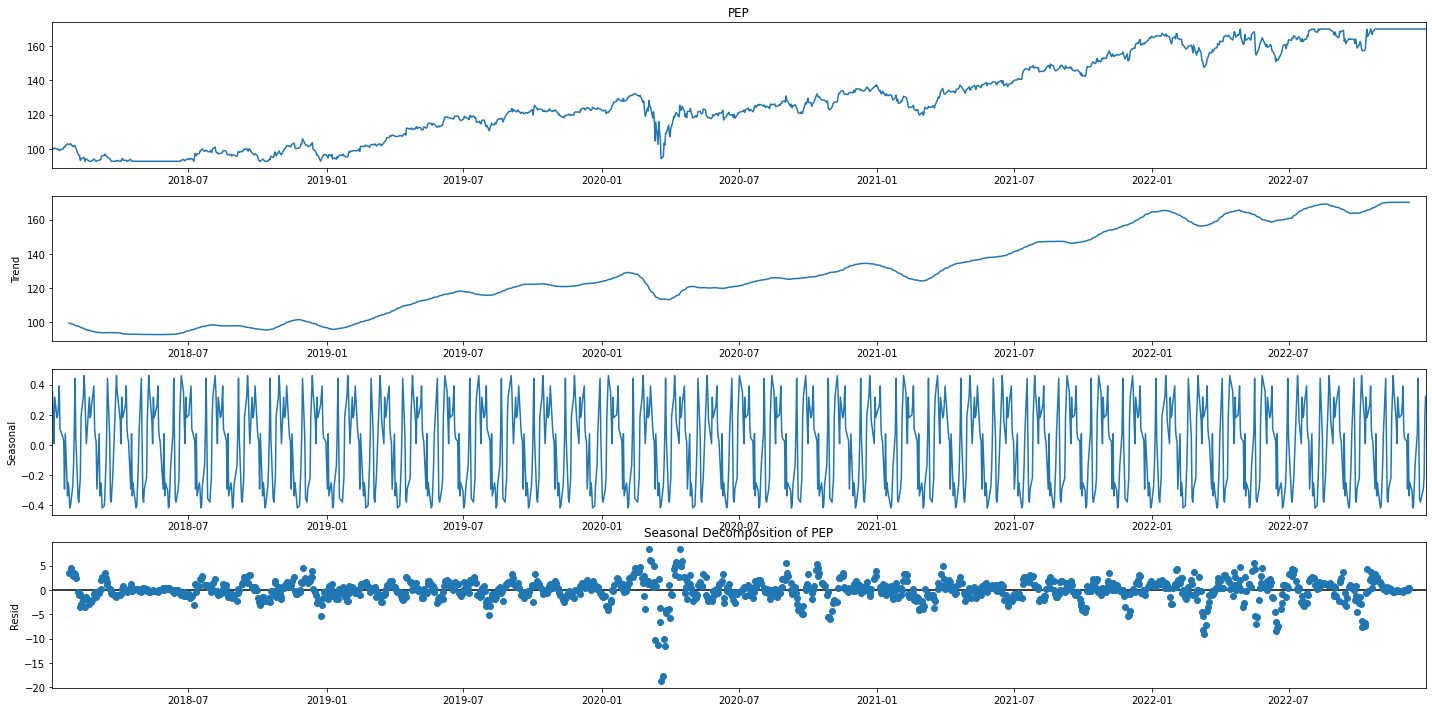

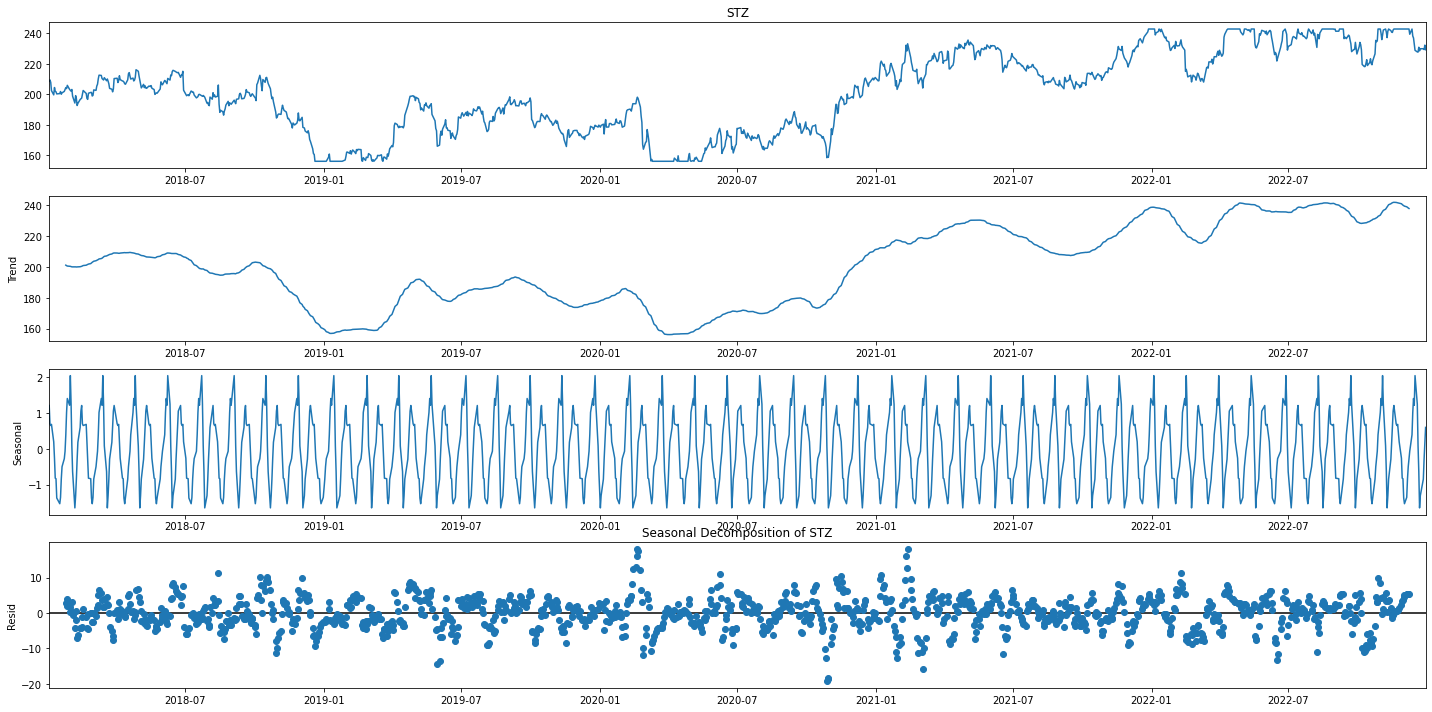

In [15]:
# Cheching Seasonal decomposition using the seasonal_decompose function
# here we assumed 30 days seasonality, hence period=30

plt.rcParams['figure.figsize'] = (20, 10)

for stock, data in stock_data.items():
    result = seasonal_decompose(data, model='additive', period=30)
    result.plot()
    
    plt.title(f'Seasonal Decomposition of {stock}')
    plt.show()


Seasonal decomposition graphs are used to break down a time series into its different components: trend, seasonality, and residual (or error) elements. These components provide insights into the underlying patterns present in the data and aid in understanding the overall behavior of the time series.

### Components of Seasonal Decomposition:

1. **Trend**:
   - The trend component represents the long-term movement or direction of the data. It highlights whether the series is generally increasing, decreasing, or stable over time.

2. **Seasonality**:
   - Seasonality captures regular, periodic fluctuations that occur at fixed intervals. For example, in monthly data, you might observe seasonality reflecting patterns that occur at the same months every year, like increased sales during the holiday season.

3. **Residual (or Error)**:
   - The residual component is the part of the series that cannot be explained by the trend or seasonality. It contains the random variations or noise in the data.

### Observations from Seasonal Decomposition Graphs:

1. **Identifying Trend and Seasonality**:
   - The decomposition allows you to visually identify the overall trend of the data and the seasonal patterns. Understanding the trend helps in forecasting long-term behavior, while recognizing seasonality aids in making predictions based on recurring patterns.

2. **Patterns Over Time**:
   - Observing consistent, repeating patterns in the seasonal component helps in understanding when peaks and troughs occur. For instance, sales spiking during holidays or a decline during certain months.

3. **Residual Analysis**:
   - Analyzing the residuals can indicate how well the trend and seasonal components explain the data. Ideally, residuals should show no specific pattern, meaning that the trend and seasonality have effectively been captured.

4. **Forecasting Insights**:
   - By separating trend, seasonality, and residuals, the decomposition helps in building models for forecasting. It provides a clearer view of how different components contribute to the overall time series behavior.

5. **Anomalies or Outliers**:
   - Sudden spikes or drops in the residual component might indicate anomalies or outliers in the data. These anomalies could be events that were not captured by the trend or seasonal patterns.

Overall, the seasonal decomposition graph provides a comprehensive understanding of the various components shaping the time series data. It aids in better modeling, trend analysis, and forecasting, enabling analysts to make more informed decisions based on the observed patterns and anomalies.

## ACF and PACF plots

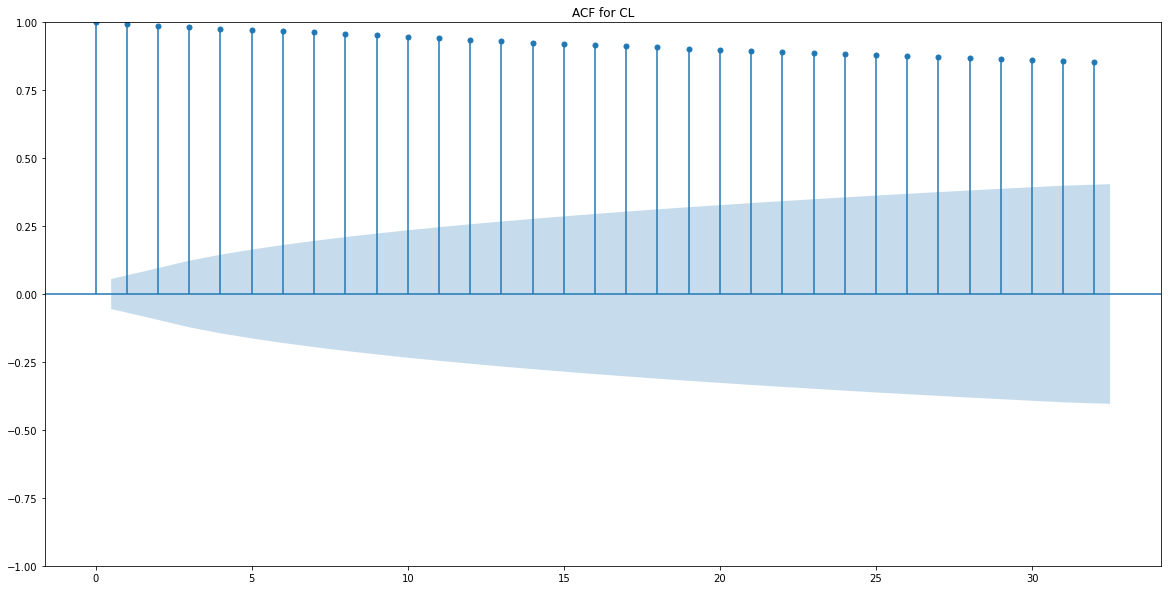

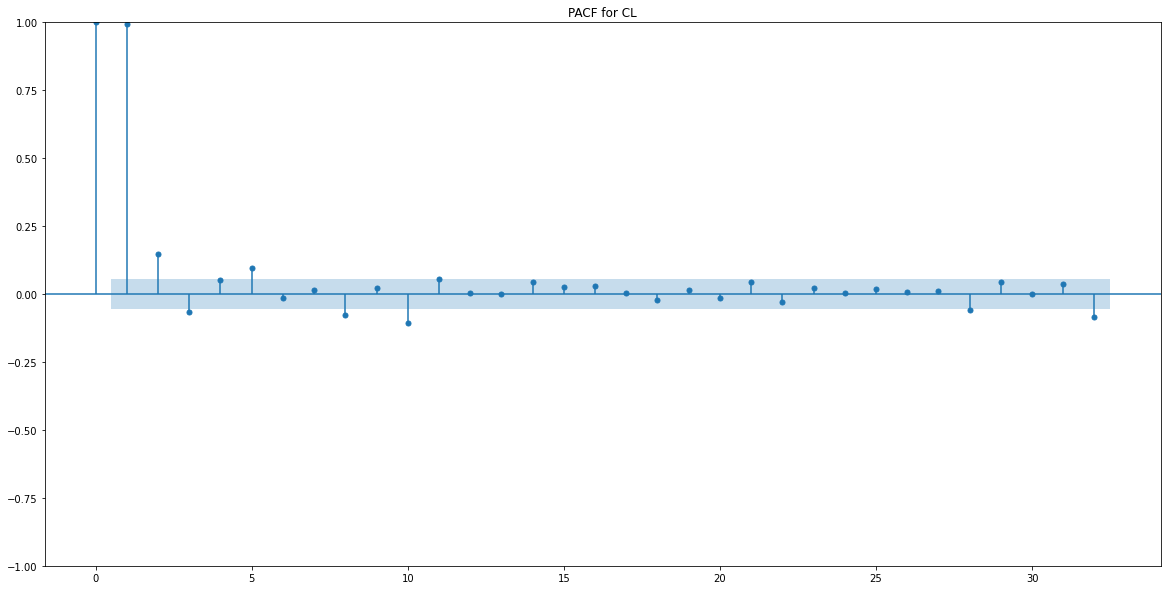

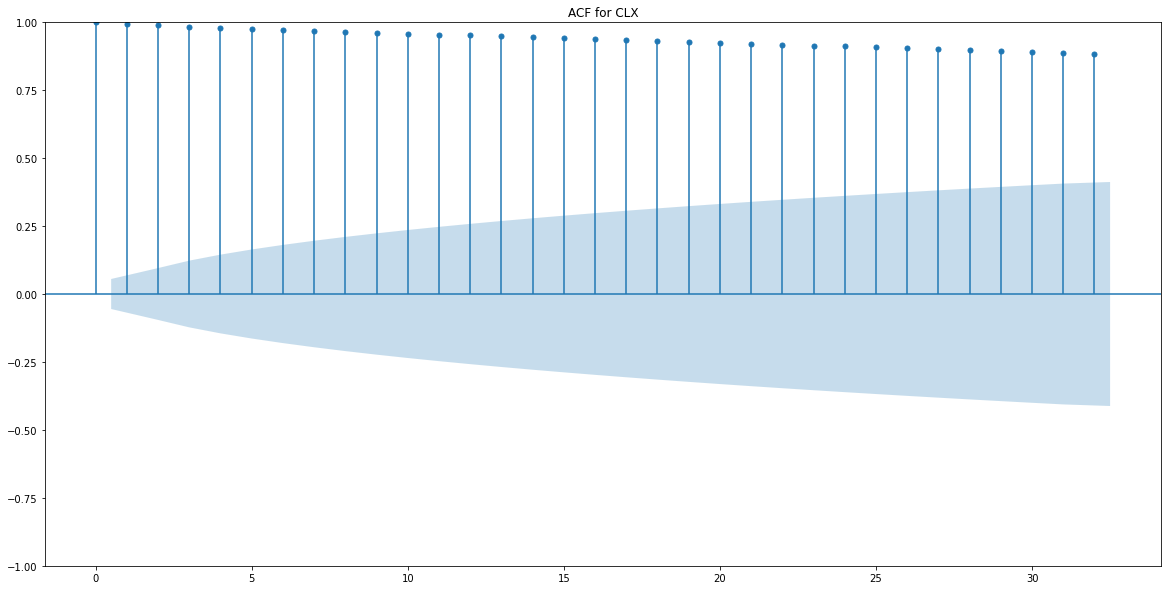

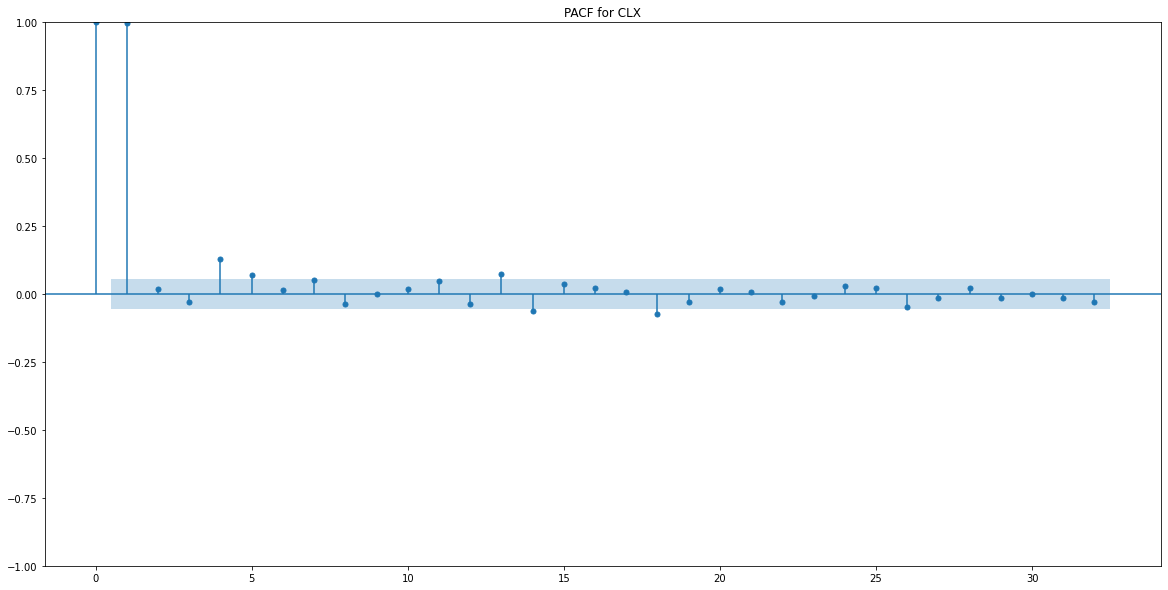

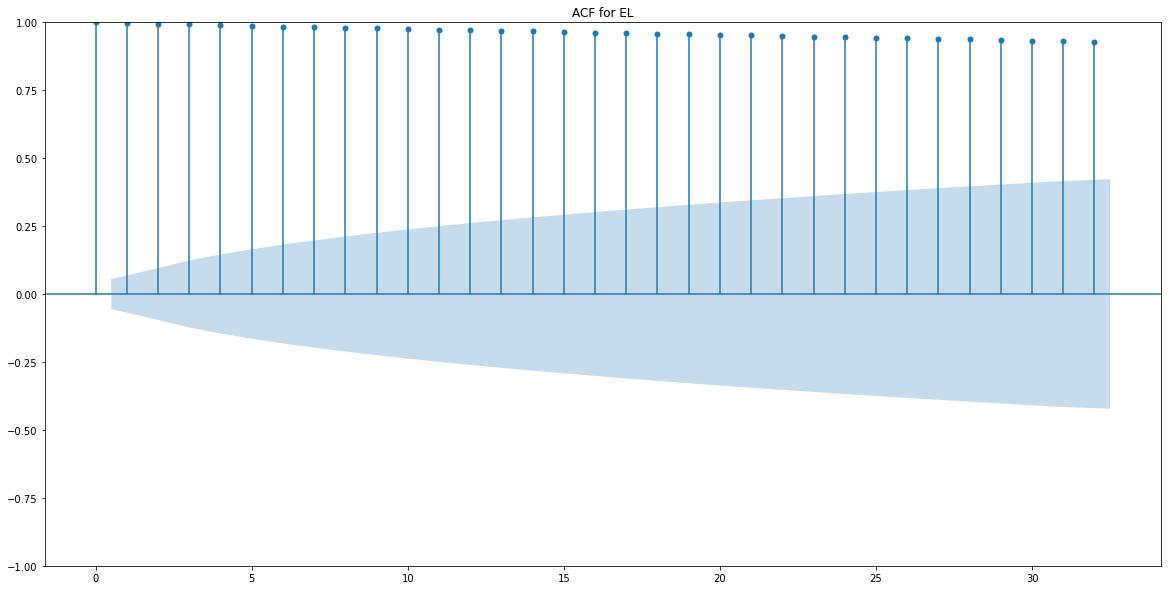

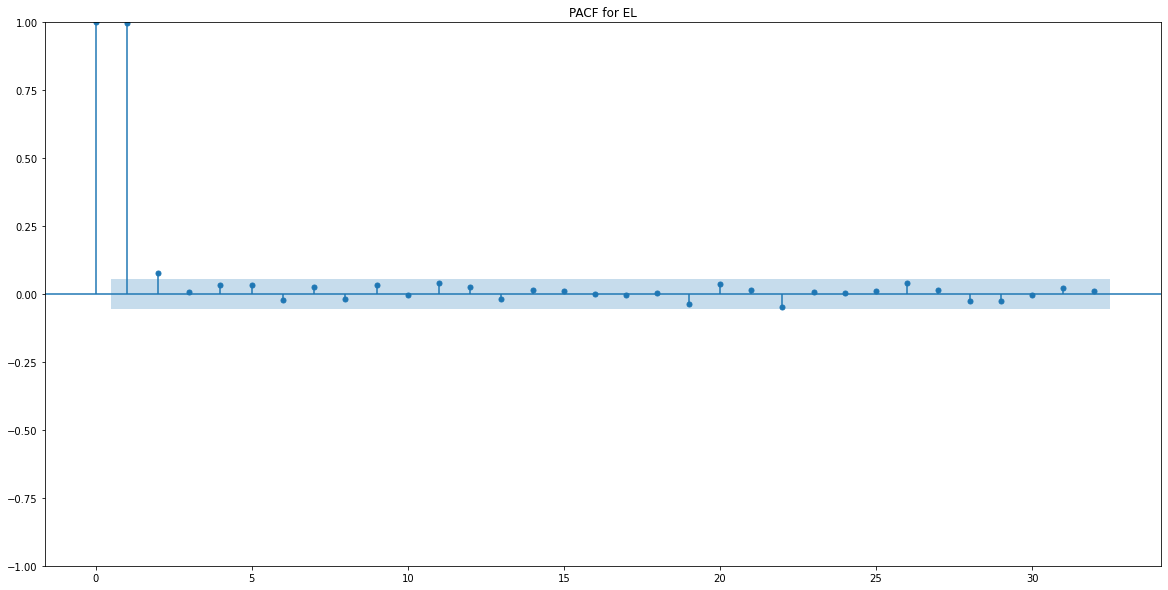

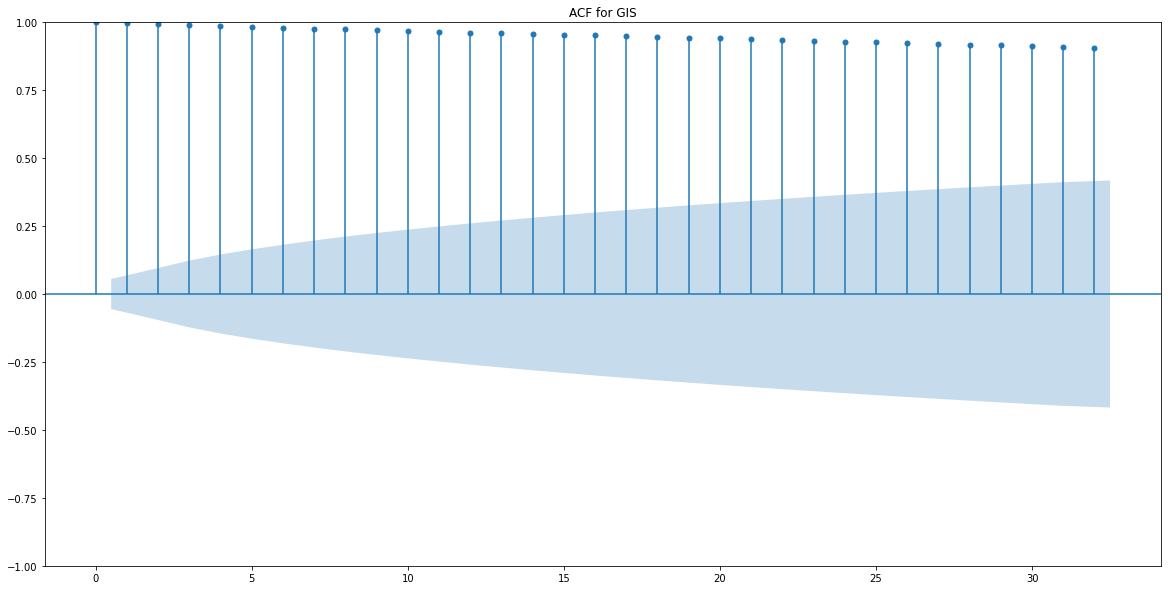

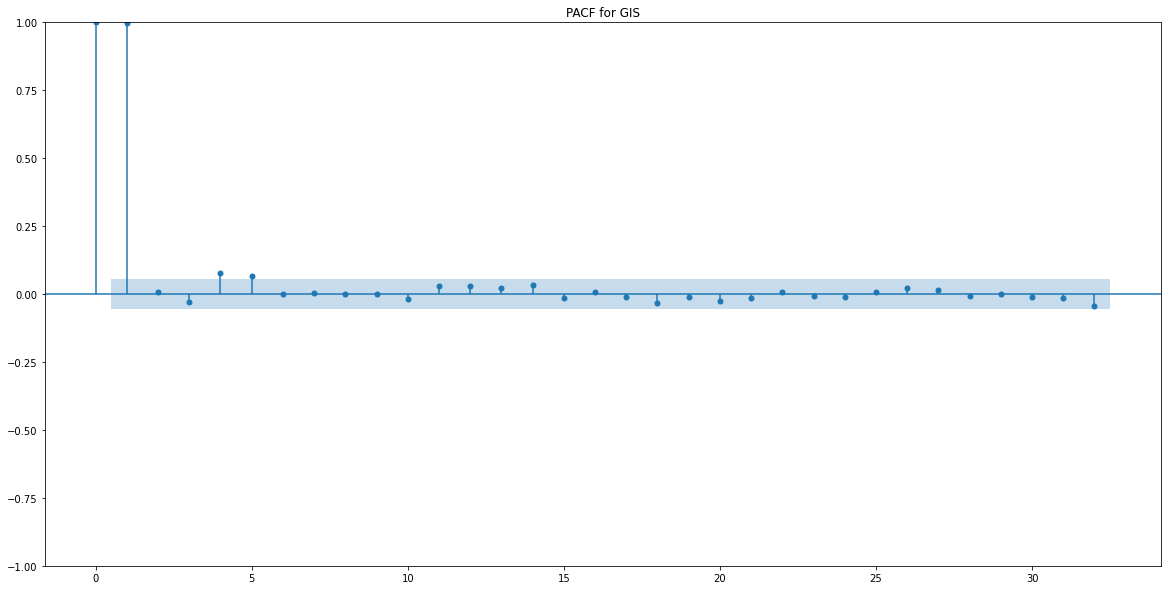

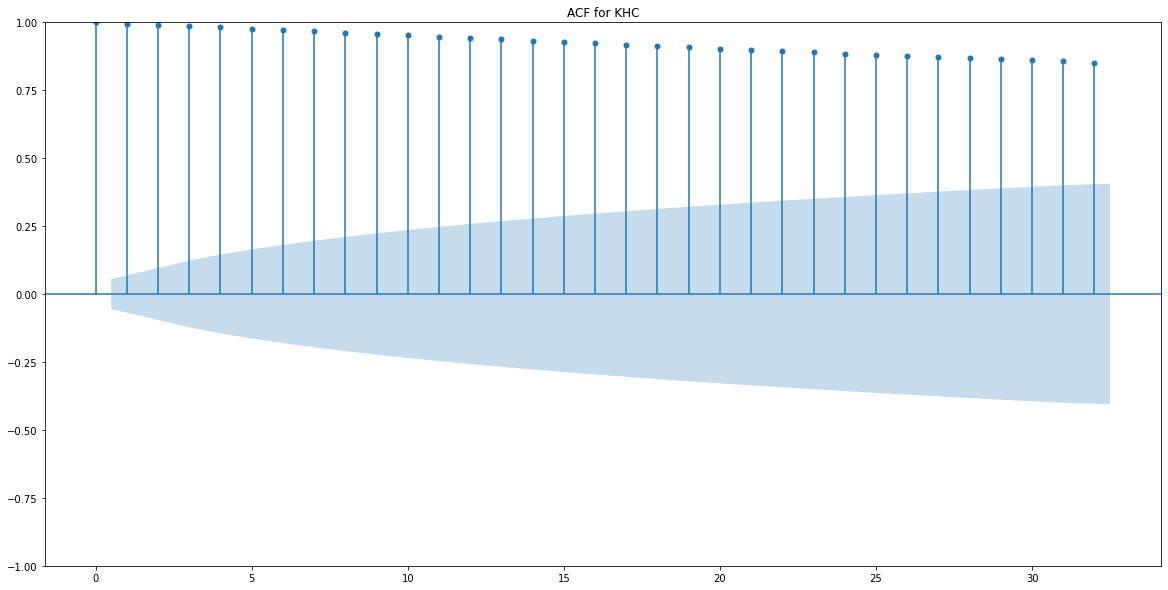

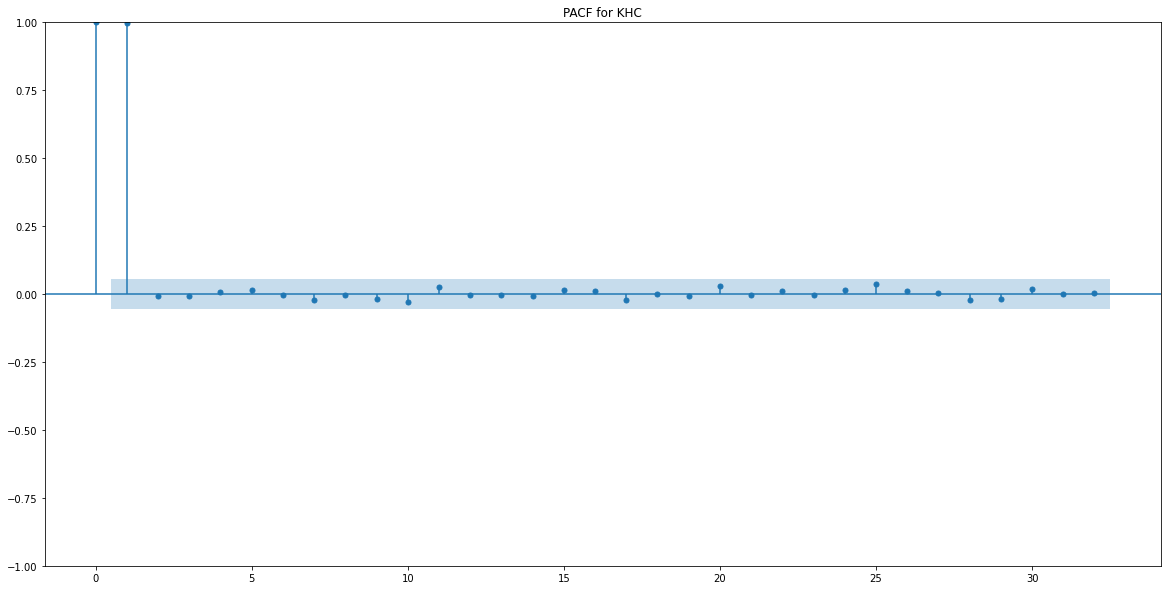

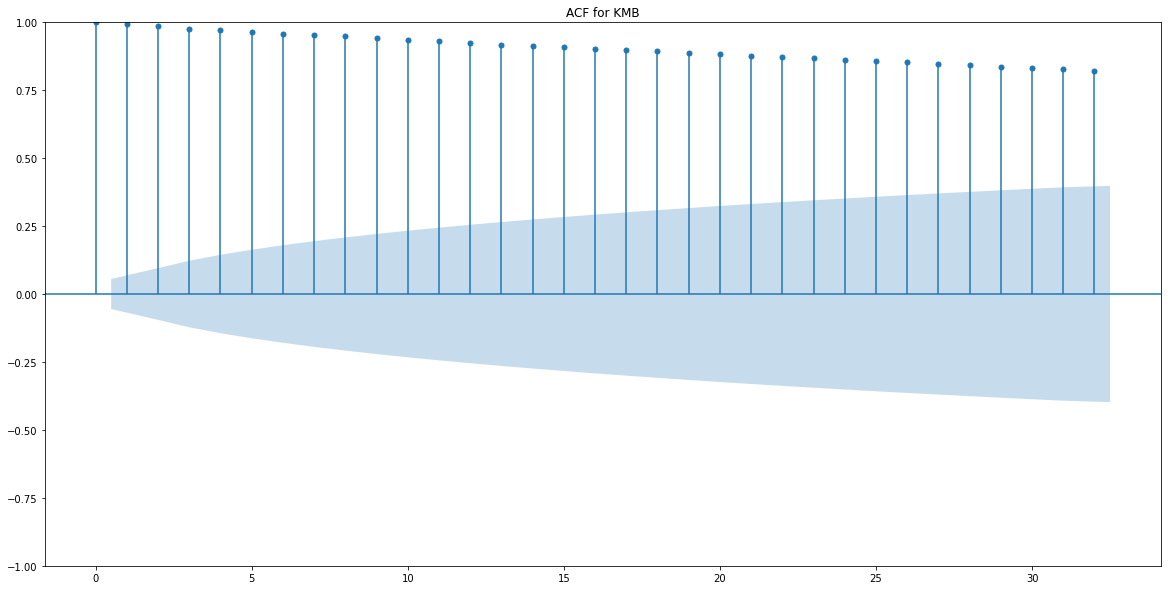

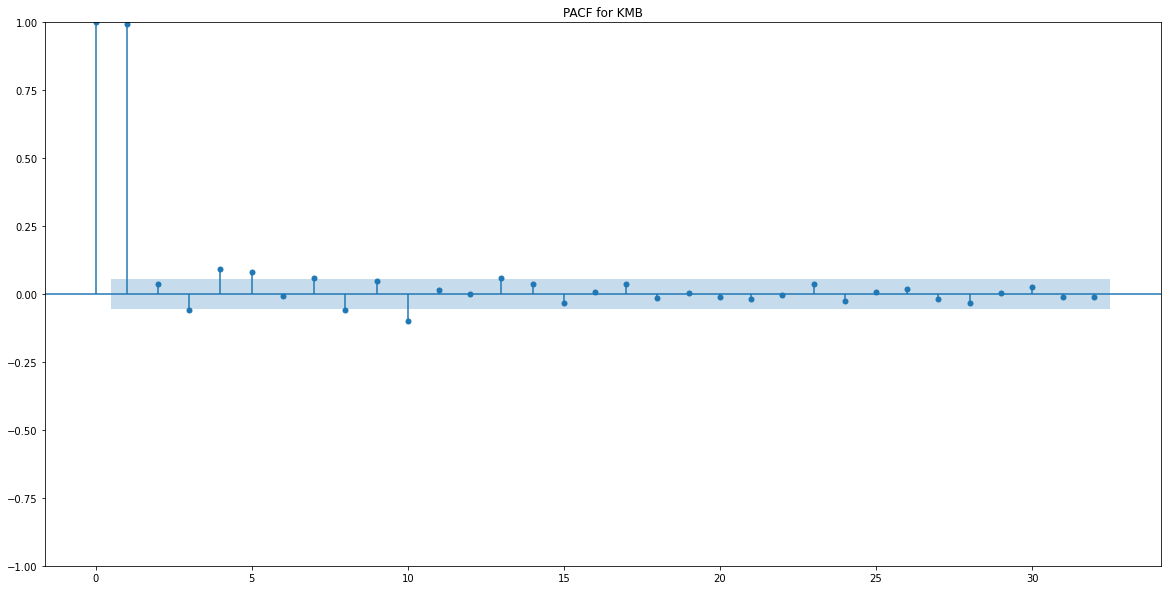

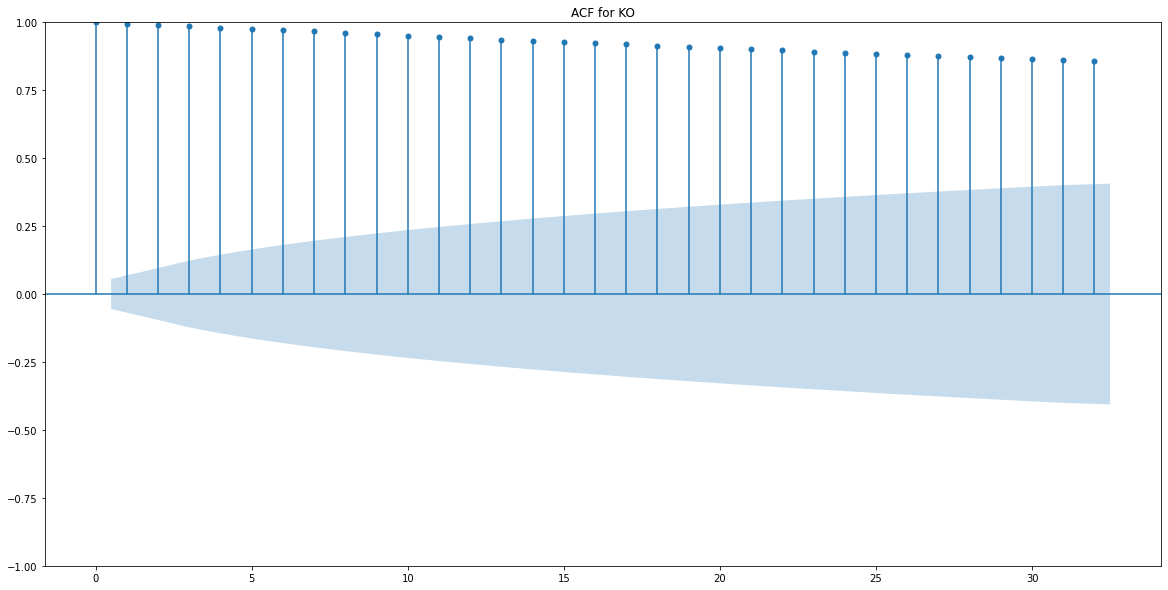

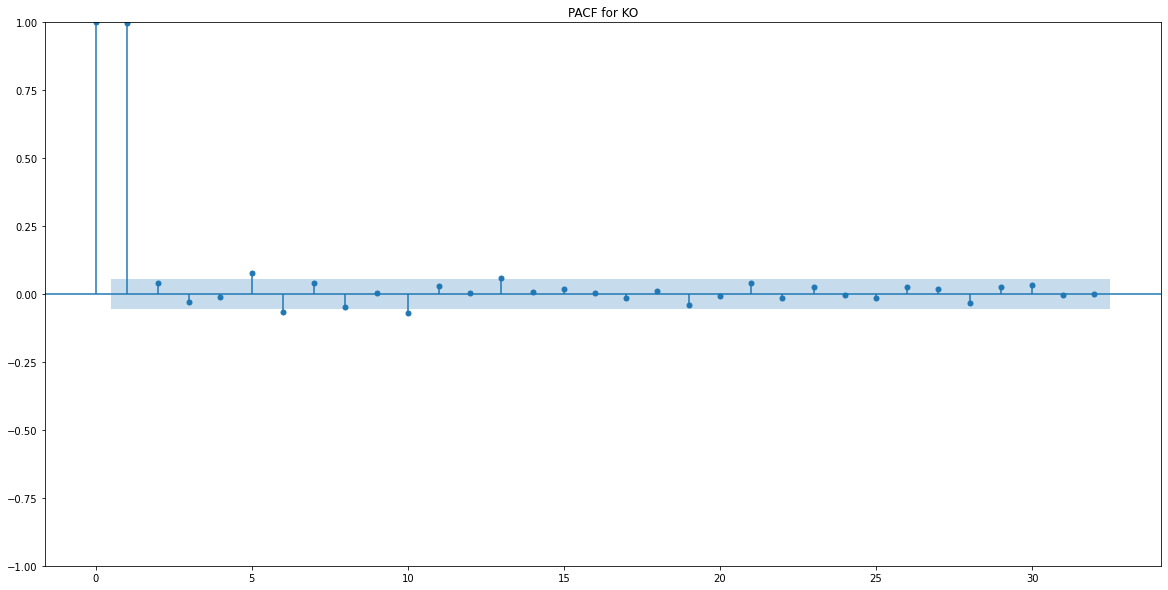

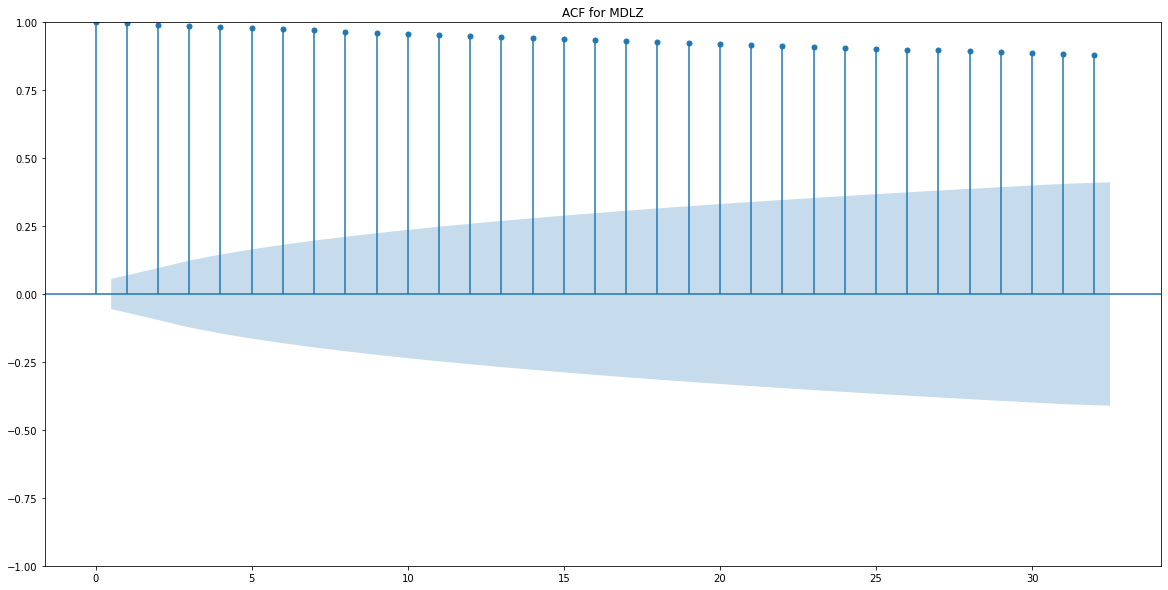

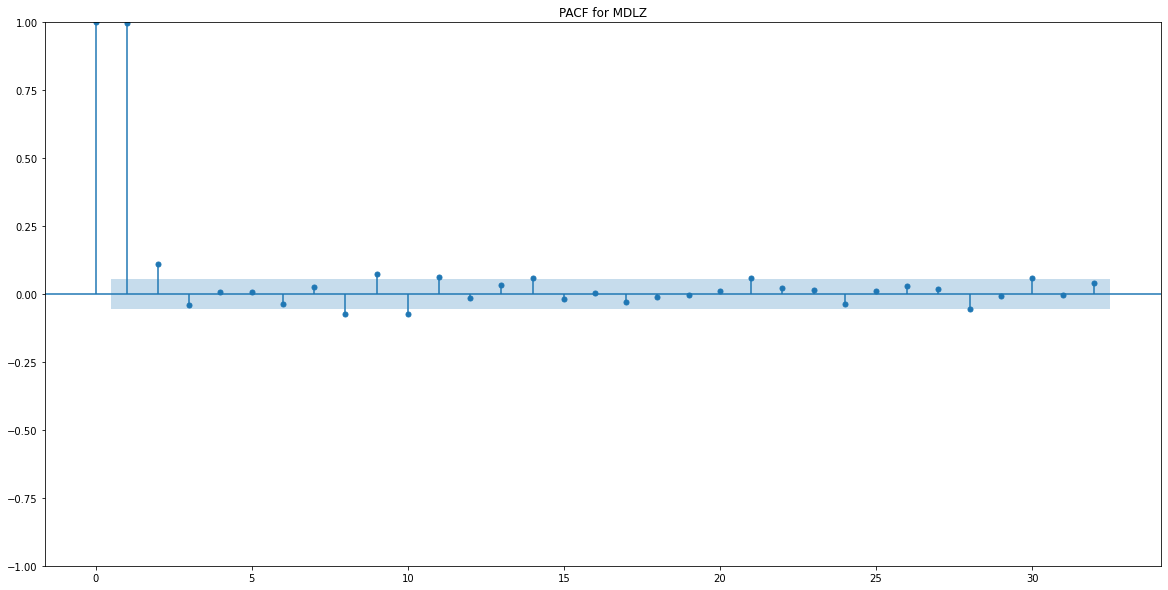

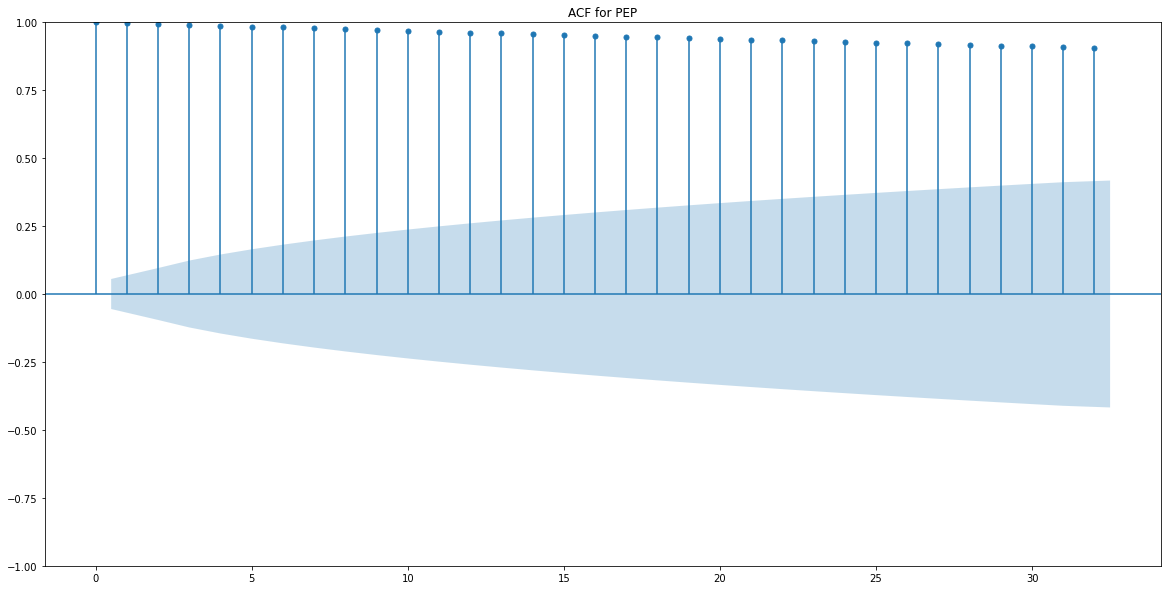

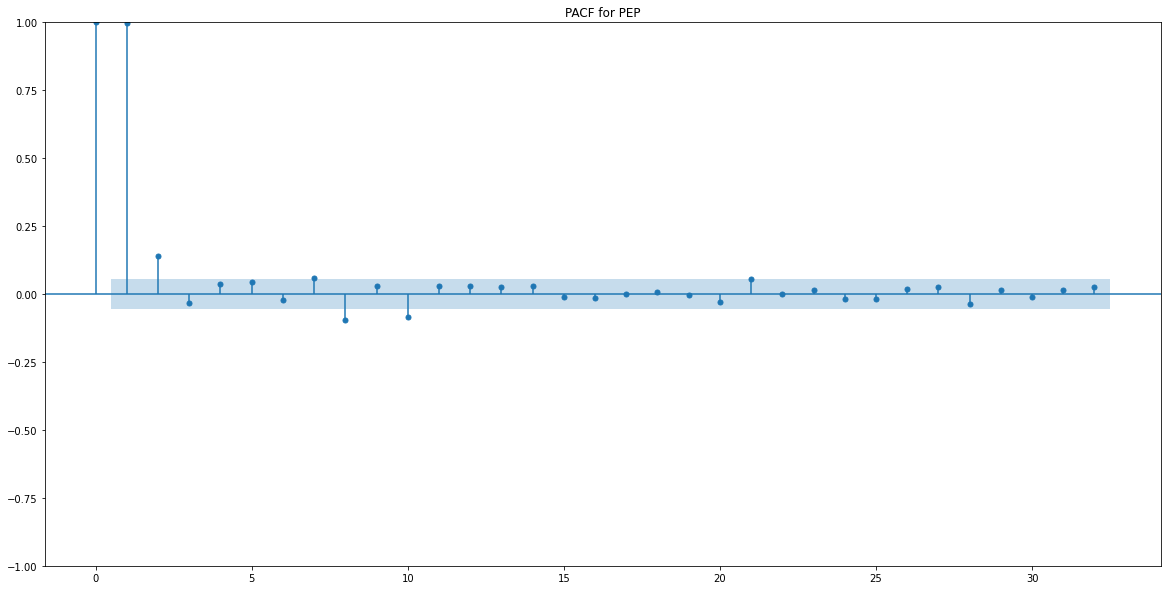

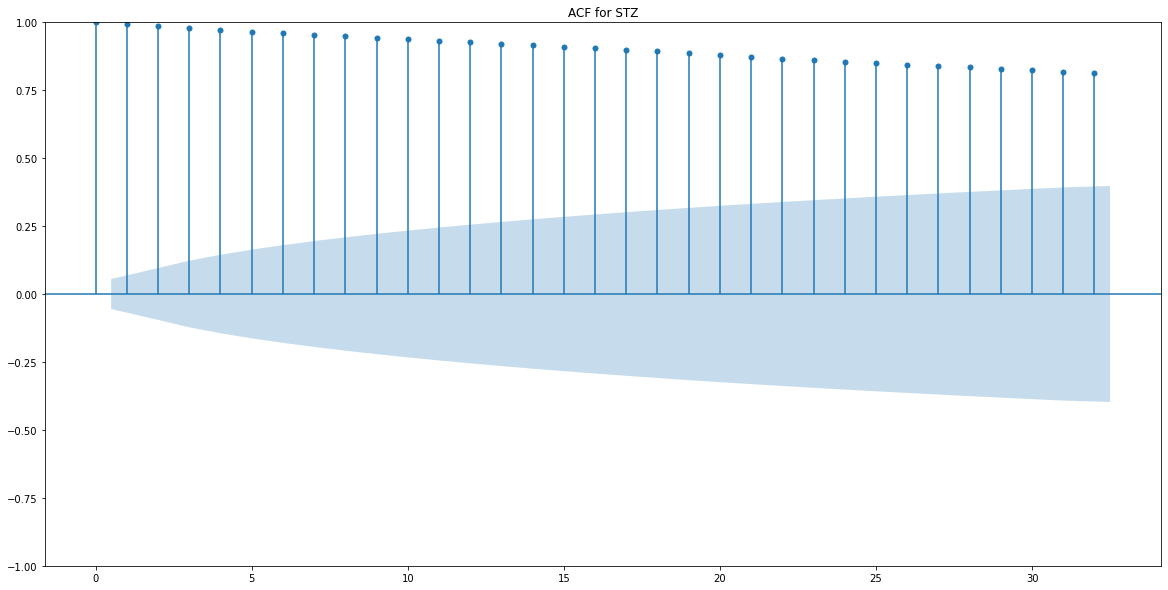

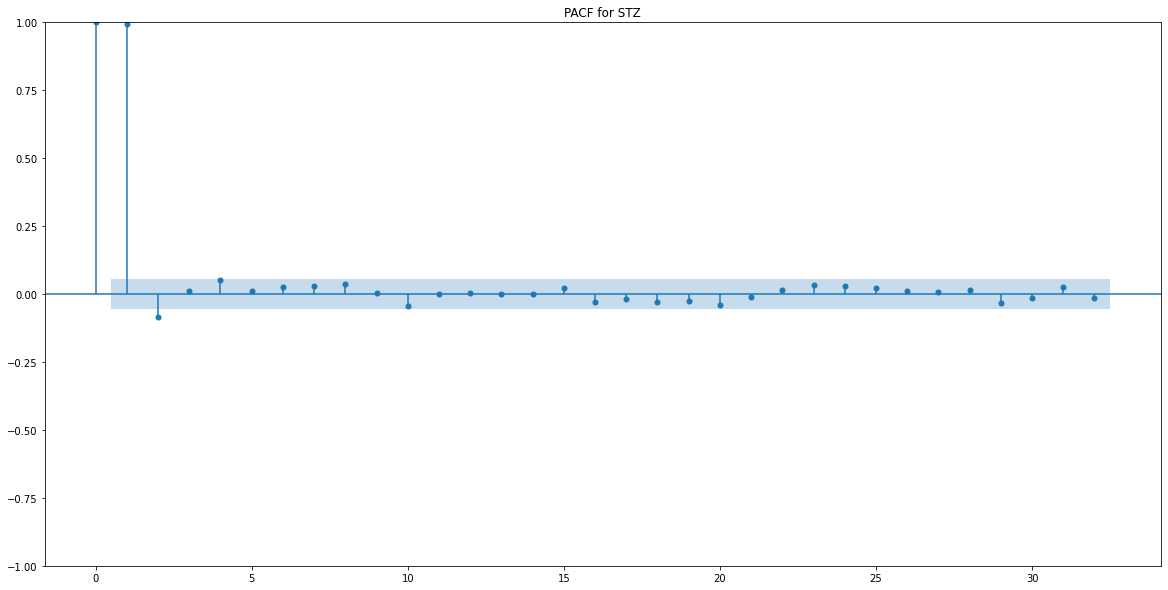

In [16]:
# ACF and PACF plots
for stock, data in stock_data.items():
    plot_acf(data)
    plt.title(f'ACF for {stock}')
    plt.show()
    
    plot_pacf(data)
    plt.title(f'PACF for {stock}')
    plt.show()


By analyzing these plots:

ACF: If the ACF plot shows a gradual decline and cuts off after a certain lag (usually q), it suggests that the series can be well-modeled using the MA term.
PACF: If the PACF plot shows a significant spike at lag 'p' and then tails off, it suggests that the series can be well-modeled using the AR term.
The plots help to identify the orders 'p' and 'q' for ARIMA models. This information is crucial for building an effective ARIMA model and improving its forecast accuracy.

Both ACF and PACF plots provide valuable insights into the underlying structure of the time series data, which is essential for selecting appropriate models and forecasting future observations accurately.

## Time Series Forecasting using ARIMA

In [17]:
# ARIMA modeling
def arima_model(data):
    # Split data into train and test sets
    train_data = data[:int(0.8 * len(data))]
    test_data = data[int(0.8 * len(data)):]

    model = ARIMA(train_data, order=(5, 1, 0))  # Example ARIMA parameters
    fitted = model.fit()

    # Forecast
    forecast = fitted.forecast(steps=len(test_data))  # Obtain forecasted values

    # Evaluate model
    mse = mean_squared_error(test_data, forecast)
    print(f'Mean Squared Error: {mse}')

for stock, data in stock_data.items():
    print(f"ARIMA modeling for {stock}:")
    arima_model(data)


ARIMA modeling for CL:
Mean Squared Error: 25.546999681646966
ARIMA modeling for CLX:
Mean Squared Error: 614.1949934725084
ARIMA modeling for EL:
Mean Squared Error: 6206.114919999149
ARIMA modeling for GIS:
Mean Squared Error: 69.24447301476744
ARIMA modeling for KHC:
Mean Squared Error: 14.02486790456202
ARIMA modeling for KMB:
Mean Squared Error: 120.38942060134126
ARIMA modeling for KO:
Mean Squared Error: 15.396035232060651
ARIMA modeling for MDLZ:
Mean Squared Error: 11.049666441893478
ARIMA modeling for PEP:
Mean Squared Error: 27.40528578830353
ARIMA modeling for STZ:
Mean Squared Error: 157.601893330189


The Mean Squared Error (MSE) values obtained from the ARIMA models provide insights into the accuracy of the models in predicting the stock prices. Lower MSE values generally indicate better predictive performance, suggesting that the model's forecasts are closer to the actual values.

Here are the observations based on the MSE values:

1. **Lowest MSE**:
   - **KHC** and **MDLZ** exhibit the lowest MSE values among the stocks. This implies that the ARIMA model fits these stocks' data quite well. The forecasted values are closer to the actual values, indicating better performance.

2. **Moderate MSE**:
   - **KO**, **PEP**, **GIS**, and **CL** have moderate MSE values. The model's performance for these stocks is relatively average, showing forecasts reasonably close to the actual values but with a bit more variance.

3. **Higher MSE**:
   - **STZ**, **KMB**, **CLX**, and **EL** have higher MSE values. These stocks demonstrate poorer model performance compared to others. The higher MSE suggests a significant difference between the forecasted and actual values, indicating that the ARIMA model might not fit these stocks' data as well.

4. **Considerations**:
   - Lower MSE values don't necessarily mean the model is perfect, but they indicate better accuracy in forecasting. Higher MSE values might suggest the need for further investigation or exploring different models or data preprocessing techniques to improve the model's performance for these stocks.

5. **Additional Analysis**:
   - It's essential to consider other factors affecting the stock prices, as the stock market can be influenced by various external factors. Testing different hyperparameters and model configurations might enhance the model's forecasting accuracy.

The MSE values provide a comparative understanding of the ARIMA model's performance for different stocks. The results can guide further refinement or consideration of alternative models for stocks with higher MSE values to improve their forecast accuracy.